In [4]:
from sage.all import (QQ, sigma, nth_prime, matrix, flatten, polygen)
import pickle
import time

Rc.<c> = QQ[]
Rn.<n> = QQ[]
Rd.<d>=QQ[]
Rkk.<kk>=QQ[]

def tau(n):
    def step1(n, k):
        return 35*k**4 - 52*k**3*n + 18*k**2*n^2

    def step2(n, k):
        return sigma(k) * sigma(n - k)

    def step3(n):
        ans = 0
        for k in range(1, n):
            ans += step1(n, k) * step2(n, k)
        return 24*ans

    return n^4 * sigma(n) - step3(n)


def tau_prime(k):
    return tau(nth_prime(k))

def P_matrix(lst):
    L = len(lst)
    columns = [lst]
    for k in range(1, L):
        column = [0]*(k-1) + [-k]
        column = flatten(column + [lst])
        column = column + [lst]
        column = column[:L]
        columns.append(column)
    return matrix(columns).transpose()


start=time.time()           
tau_prime_list=[(k,tau_prime(k)) for k in range(1,40)]
h_list=[[0,1]]+tau_prime_list  
c_polys=[]
c_cffs=[]

for n in range(2,10):
    print("n:",n)
    data=[]
    
    for c in range (1,n+5):
        j_c_list=[(0,c)]
        
        for k in range(1,n+1):
            sm=0
            
            for r in range(1,k):
                sm+=j_c_list[r][1]*h_list[k-r][1] 
    
            j_k=k*h_list[k][1]-sm
            j_c_list.append((k,j_k))
    
        sliced = j_c_list[:n]
        inputs = [pair[1] for pair in sliced]
        det = P_matrix(inputs).det()
        data.append((c, det))
        
    c_poly = Rc.lagrange_polynomial(data)
    

    c_polys.append((n, c_poly))
    
for pair in c_polys:
    print("n:",pair[0])
    print(pair[1])
    print()    
print("elapsed seconds:",time.time()-start)

n: 2
n: 3
n: 4
n: 5
n: 6
n: 7
n: 8
n: 9
n: 2
c^2 - 24

n: 3
c^3 - 72*c - 144

n: 4
c^4 - 144*c^2 - 576*c + 114588

n: 5
c^5 - 240*c^3 - 1440*c^2 + 572940*c + 12479232

n: 6
c^6 - 360*c^4 - 2880*c^3 + 1718820*c^2 + 74875392*c + 1198192320

n: 7
c^7 - 504*c^5 - 5040*c^4 + 4010580*c^3 + 262063872*c^2 + 8387346240*c + 17919600192

n: 8
c^8 - 672*c^6 - 8064*c^5 + 8021160*c^4 + 698836992*c^3 + 33549384960*c^2 + 143356801536*c - 20578729954608

n: 9
c^9 - 864*c^7 - 12096*c^6 + 14438088*c^5 + 1572383232*c^4 + 100648154880*c^3 + 645105606912*c^2 - 185208569591472*c - 6136737862569984

elapsed seconds: 0.06967973709106445


In [2]:
import pickle
import time
from sage.all import QQ, sigma, nth_prime, matrix, flatten, polygen, RR, CC, factorial
import ast
import math
from scipy.signal import find_peaks, correlate
from scipy.fft import fft, fftfreq
import numpy as np

Rc.<c> = QQ[] 

def tau(n):
    def step1(n, k):
        return 35*k**4 - 52*k**3*n + 18*k**2*n**2
    def step2(n, k):
        return sigma(k) * sigma(n - k)
    def step3(n):
        ans = 0
        for k in range(1, n):
            ans = ans + step1(n, k) * step2(n, k)
        return 24*ans
    return n**4 * sigma(n) - step3(n)

def tau_prime(k):
    pn = nth_prime(k)
    return tau(pn)

def P_matrix(lst):
    lenlist = len(lst)
    columns = [lst]
    for k in range(1, lenlist):
        column = [0]*(k-1)
        column = column + [-k]
        column = flatten(column + [lst])
        column = column + [lst]
        column = column[:lenlist]
        columns += [column]
    return (matrix(columns)).transpose()

precision_bits = 100
x = polygen(QQ)
start=time.time()
tau_prime_list = [(k, tau_prime(k)) for k in range(1, 40)]
h_list = [(0, 1)] + tau_prime_list  # h_list[k] = (k, h[k]) where h[0]=1, h[k]=tau(p_k)
c_polys = []

for n in range(2, 10):
    print("n:", n)
    
    points_for_interpolation = []
    
    for c_val in range(1, n+5):
        # Build j_c_list to match the structure of the correct cell
        j_c_list = [(0, c_val)]  # j_c_list[0] = (0, c_val), representing j[1] = c_val
        
        for k in range(1, n+1):
            sm = 0
            for r in range(1, k):
                sm += j_c_list[r][1] * h_list[k-r][1]
            j_k = k * h_list[k][1] - sm
            j_c_list.append((k, j_k))
        
        # Now compute h_c using equation D1
        # h_c[0] = 1, and h_c[k] = (1/k) * Σ(r=1 to k) j_c[r] * h_c[k-r]
        # But j_c_list[r] corresponds to j[r+1], so we need to adjust indices
        
        # Actually, let me extract j values properly:
        # j_c_list[0][1] is j[1], j_c_list[1][1] is j[2], etc.
        j_values = [0] + [j_c_list[i][1] for i in range(len(j_c_list))]  # j_values[k] = j[k]
        
        h_c = [1]  # h_c[0] = 1
        for k in range(1, n+1):
            sm = 0
            for r in range(1, k+1):
                sm += j_values[r] * h_c[k-r]
            h_c.append(sm / k)
        
        points_for_interpolation.append((c_val, h_c[n] * factorial(n)))
    
    c_poly = Rc.lagrange_polynomial(points_for_interpolation)
    c_polys.append((n, c_poly))

for pair in c_polys:
    print("n:", pair[0])
    print(pair[1])
    print()
print(time.time()-start)

n: 2
n: 3
n: 4
n: 5
n: 6
n: 7
n: 8
n: 9
n: 2
c^2 - 24

n: 3
c^3 - 72*c - 144

n: 4
c^4 - 144*c^2 - 576*c + 114588

n: 5
c^5 - 240*c^3 - 1440*c^2 + 572940*c + 12479232

n: 6
c^6 - 360*c^4 - 2880*c^3 + 1718820*c^2 + 74875392*c + 1198192320

n: 7
c^7 - 504*c^5 - 5040*c^4 + 4010580*c^3 + 262063872*c^2 + 8387346240*c + 17919600192

n: 8
c^8 - 672*c^6 - 8064*c^5 + 8021160*c^4 + 698836992*c^3 + 33549384960*c^2 + 143356801536*c - 20578729954608

n: 9
c^9 - 864*c^7 - 12096*c^6 + 14438088*c^5 + 1572383232*c^4 + 100648154880*c^3 + 645105606912*c^2 - 185208569591472*c - 6136737862569984

0.061615943908691406


In [5]:
import pickle
import time
from sage.all import QQ, sigma, nth_prime, matrix, flatten, polygen, RR, CC, factorial
import ast
import math
from scipy.signal import find_peaks, correlate
from scipy.fft import fft, fftfreq
import numpy as np

Rc.<c> = QQ[] 

def tau(n):
    def step1(n, k):
        return 35*k**4 - 52*k**3*n + 18*k**2*n**2
    def step2(n, k):
        return sigma(k) * sigma(n - k)
    def step3(n):
        ans = 0
        for k in range(1, n):
            ans = ans + step1(n, k) * step2(n, k)
        return 24*ans
    return n**4 * sigma(n) - step3(n)

def tau_prime(k):
    pn = nth_prime(k)
    return tau(pn)

def P_matrix(lst):
    lenlist = len(lst)
    columns = [lst]
    for k in range(1, lenlist):
        column = [0]*(k-1)
        column = column + [-k]
        column = flatten(column + [lst])
        column = column + [lst]
        column = column[:lenlist]
        columns += [column]
    return (matrix(columns)).transpose()

precision_bits = 100
x = polygen(QQ)
start=time.time()
tau_prime_list = [(k, tau_prime(k)) for k in range(1, 40)]
h_list = [(0, 1)] + tau_prime_list  # h_list[k] = (k, h[k]) where h[0]=1, h[k]=tau(p_k)
c_polys = []

for n in range(2, 10):
    print((n,time.time()-start))
    
    points_for_interpolation = []
    
    for c_val in range(1, n+5):
        # Build j_c_list to match the structure of the correct cell
        j_c_list = [(0, c_val)]  # j_c_list[0] = (0, c_val), representing j[1] = c_val
        
        for k in range(1, n+1):
            sm = 0
            for r in range(1, k):
                sm += j_c_list[r][1] * h_list[k-r][1]
            j_k = k * h_list[k][1] - sm
            j_c_list.append((k, j_k))
        
        # Now compute h_c using equation D1
        # h_c[0] = 1, and h_c[k] = (1/k) * Σ(r=1 to k) j_c[r] * h_c[k-r]
        # But j_c_list[r] corresponds to j[r+1], so we need to adjust indices
        
        # Actually, let me extract j values properly:
        # j_c_list[0][1] is j[1], j_c_list[1][1] is j[2], etc.
        j_values = [0] + [j_c_list[i][1] for i in range(len(j_c_list))]  # j_values[k] = j[k]
        
        h_c = [1]  # h_c[0] = 1
        for k in range(1, n+1):
            sm = 0
            for r in range(1, k+1):
                sm += j_values[r] * h_c[k-r]
            h_c.append(sm / k)
        
        points_for_interpolation.append((c_val, h_c[n] * factorial(n)))
    
    c_poly = Rc.lagrange_polynomial(points_for_interpolation)
    c_polys.append((n, c_poly))

for pair in c_polys:
    print("n:", pair[0])
    print(pair[1])
    print()

with open('/Users/barrybrent/data2/run9feb26no8.txt', 'wb') as wfile:
    pickle.dump(c_polys, wfile) 

(2, 0.06065511703491211)
(3, 0.06196284294128418)
(4, 0.06226611137390137)
(5, 0.06267094612121582)
(6, 0.06322693824768066)
(7, 0.06435608863830566)
(8, 0.06642985343933105)
(9, 0.06835389137268066)
n: 2
c^2 - 24

n: 3
c^3 - 72*c - 144

n: 4
c^4 - 144*c^2 - 576*c + 114588

n: 5
c^5 - 240*c^3 - 1440*c^2 + 572940*c + 12479232

n: 6
c^6 - 360*c^4 - 2880*c^3 + 1718820*c^2 + 74875392*c + 1198192320

n: 7
c^7 - 504*c^5 - 5040*c^4 + 4010580*c^3 + 262063872*c^2 + 8387346240*c + 17919600192

n: 8
c^8 - 672*c^6 - 8064*c^5 + 8021160*c^4 + 698836992*c^3 + 33549384960*c^2 + 143356801536*c - 20578729954608

n: 9
c^9 - 864*c^7 - 12096*c^6 + 14438088*c^5 + 1572383232*c^4 + 100648154880*c^3 + 645105606912*c^2 - 185208569591472*c - 6136737862569984



In [2]:
import pickle
with open('/Users/barrybrent/data2/run9feb26no9.txt', 'rb') as rfile:
    c_polys = pickle.load(rfile)

for pair in c_polys[:20]:
    print(pair)

(2, c^2 - 24)
(3, c^3 - 72*c - 144)
(4, c^4 - 144*c^2 - 576*c + 114588)
(5, c^5 - 240*c^3 - 1440*c^2 + 572940*c + 12479232)
(6, c^6 - 360*c^4 - 2880*c^3 + 1718820*c^2 + 74875392*c + 1198192320)
(7, c^7 - 504*c^5 - 5040*c^4 + 4010580*c^3 + 262063872*c^2 + 8387346240*c + 17919600192)
(8, c^8 - 672*c^6 - 8064*c^5 + 8021160*c^4 + 698836992*c^3 + 33549384960*c^2 + 143356801536*c - 20578729954608)
(9, c^9 - 864*c^7 - 12096*c^6 + 14438088*c^5 + 1572383232*c^4 + 100648154880*c^3 + 645105606912*c^2 - 185208569591472*c - 6136737862569984)
(10, c^10 - 1080*c^8 - 17280*c^7 + 24063480*c^6 + 3144766464*c^5 + 251620387200*c^4 + 2150352023040*c^3 - 926042847957360*c^2 - 61367378625699840*c - 1015814349610805376)
(11, c^11 - 1320*c^9 - 23760*c^8 + 37814040*c^7 + 5765405184*c^6 + 553564851840*c^5 + 5913468063360*c^4 - 3395490442510320*c^3 - 337520582441349120*c^2 - 11173957845718859136*c - 48059370493945125120)
(12, c^12 - 1584*c^10 - 31680*c^9 + 56721060*c^8 + 9883551744*c^7 + 1107129703680*c^6 + 14192

In [1]:
import pickle
import time
from sage.all import QQ, sigma, nth_prime, matrix, flatten, polygen, RR, CC, factorial
import ast
import math
from scipy.signal import find_peaks, correlate
from scipy.fft import fft, fftfreq
import numpy as np

Rc.<c> = QQ[] 

def tau(n):
    def step1(n, k):
        return 35*k**4 - 52*k**3*n + 18*k**2*n**2
    def step2(n, k):
        return sigma(k) * sigma(n - k)
    def step3(n):
        ans = 0
        for k in range(1, n):
            ans = ans + step1(n, k) * step2(n, k)
        return 24*ans
    return n**4 * sigma(n) - step3(n)

def tau_prime(k):
    pn = nth_prime(k)
    return tau(pn)

def P_matrix(lst):
    lenlist = len(lst)
    columns = [lst]
    for k in range(1, lenlist):
        column = [0]*(k-1)
        column = column + [-k]
        column = flatten(column + [lst])
        column = column + [lst]
        column = column[:lenlist]
        columns += [column]
    return (matrix(columns)).transpose()

precision_bits = 100
x = polygen(QQ)
start=time.time()
tau_prime_list = [(k, tau_prime(k)) for k in range(1, 301)]
h_list = [(0, 1)] + tau_prime_list  # h_list[k] = (k, h[k]) where h[0]=1, h[k]=tau(p_k)
c_polys = []

for n in range(2, 300):
    print((n,time.time()-start))
    
    points_for_interpolation = []
    
    for c_val in range(1, n+5):
        # Build j_c_list to match the structure of the correct cell
        j_c_list = [(0, c_val)]  # j_c_list[0] = (0, c_val), representing j[1] = c_val
        
        for k in range(1, n+1):
            sm = 0
            for r in range(1, k):
                sm += j_c_list[r][1] * h_list[k-r][1]
            j_k = k * h_list[k][1] - sm
            j_c_list.append((k, j_k))
        
        # Now compute h_c using equation D1
        # h_c[0] = 1, and h_c[k] = (1/k) * Σ(r=1 to k) j_c[r] * h_c[k-r]
        # But j_c_list[r] corresponds to j[r+1], so we need to adjust indices
        
        # Actually, let me extract j values properly:
        # j_c_list[0][1] is j[1], j_c_list[1][1] is j[2], etc.
        j_values = [0] + [j_c_list[i][1] for i in range(len(j_c_list))]  # j_values[k] = j[k]
        
        h_c = [1]  # h_c[0] = 1
        for k in range(1, n+1):
            sm = 0
            for r in range(1, k+1):
                sm += j_values[r] * h_c[k-r]
            h_c.append(sm / k)
        
        points_for_interpolation.append((c_val, h_c[n] * factorial(n)))
    
    c_poly = Rc.lagrange_polynomial(points_for_interpolation)
    c_polys.append((n, c_poly))

for pair in c_polys:
    print("n:", pair[0])
    print(pair[1])
    print()

with open('/Users/barrybrent/data2/run9feb26no9.txt', 'wb') as wfile:
    pickle.dump(c_polys, wfile) 

(2, 4.771606922149658)
(3, 4.7760910987854)
(4, 4.776532173156738)
(5, 4.776918888092041)
(6, 4.777416229248047)
(7, 4.778057098388672)
(8, 4.779520034790039)
(9, 4.7810752391815186)
(10, 4.782430171966553)
(11, 4.784212827682495)
(12, 4.786579132080078)
(13, 4.789204835891724)
(14, 4.793962240219116)
(15, 4.798079967498779)
(16, 4.803730010986328)
(17, 4.8097288608551025)
(18, 4.816928863525391)
(19, 4.824954986572266)
(20, 4.834187984466553)
(21, 4.844279050827026)
(22, 4.857187032699585)
(23, 4.870628118515015)
(24, 4.886313199996948)
(25, 4.903577089309692)
(26, 4.92340612411499)
(27, 4.945106029510498)
(28, 4.96874213218689)
(29, 4.994373083114624)
(30, 5.022153854370117)
(31, 5.060878038406372)
(32, 5.097027063369751)
(33, 5.1367270946502686)
(34, 5.176694869995117)
(35, 5.2193920612335205)
(36, 5.274280071258545)
(37, 5.336647033691406)
(38, 5.398096084594727)
(39, 5.464267015457153)
(40, 5.5344061851501465)
(41, 5.618198871612549)
(42, 5.700067043304443)
(43, 5.789289236068726)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

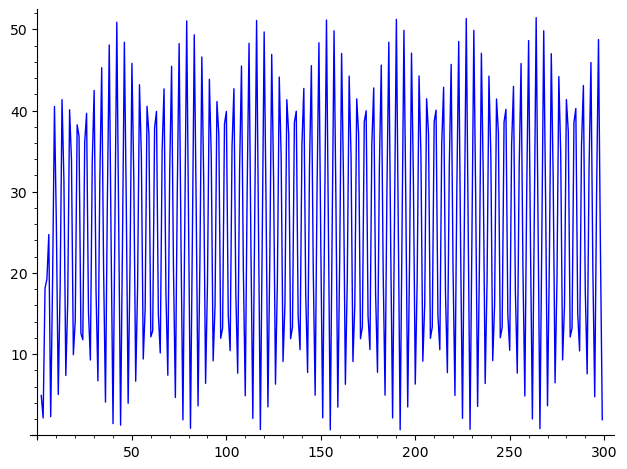

LOG MINIMUM MODULI


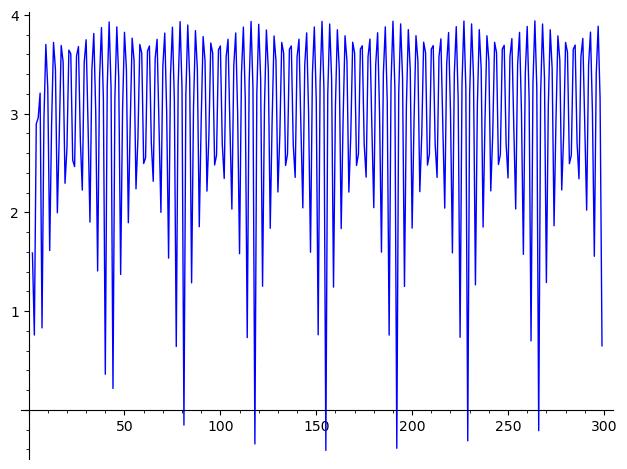

Data range: n = 2 to 299
Number of data points: 298
Min modulus range: 0.663745 to 51.440233

Trend removed. Detrended data std dev: 0.9391

TOP DOMINANT PERIODICITIES (in index n)
Rank   Period       Frequency    Power          
----------------------------------------------------------------------
1            4.14     0.241611       1.27e+04
2            2.06     0.486577       3.98e+03
3            3.68     0.271812       1.34e+03


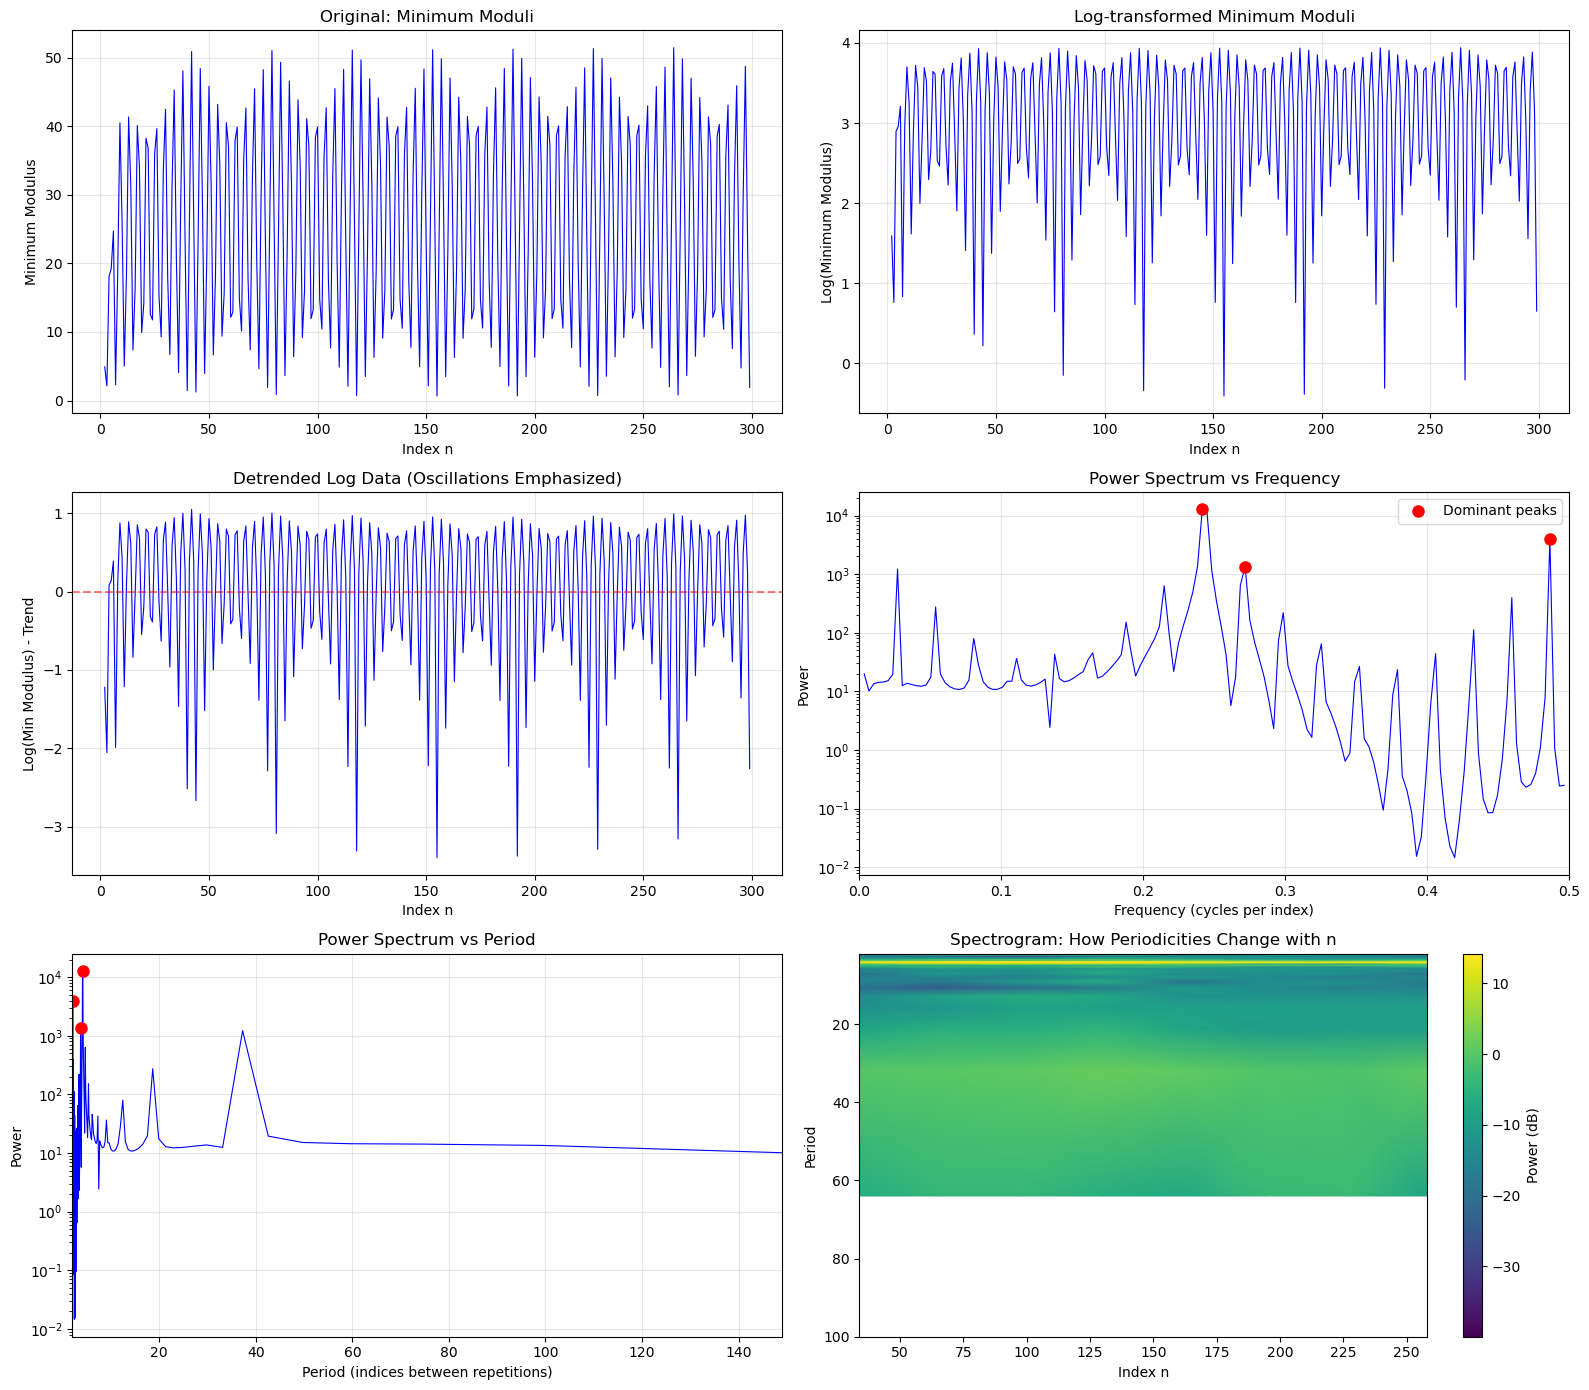


SIGNAL RECONSTRUCTION
Component 1: Period = 4.14, Amplitude = 0.1232
Component 2: Period = 2.06, Amplitude = 0.0095
Component 3: Period = 3.68, Amplitude = 0.0858


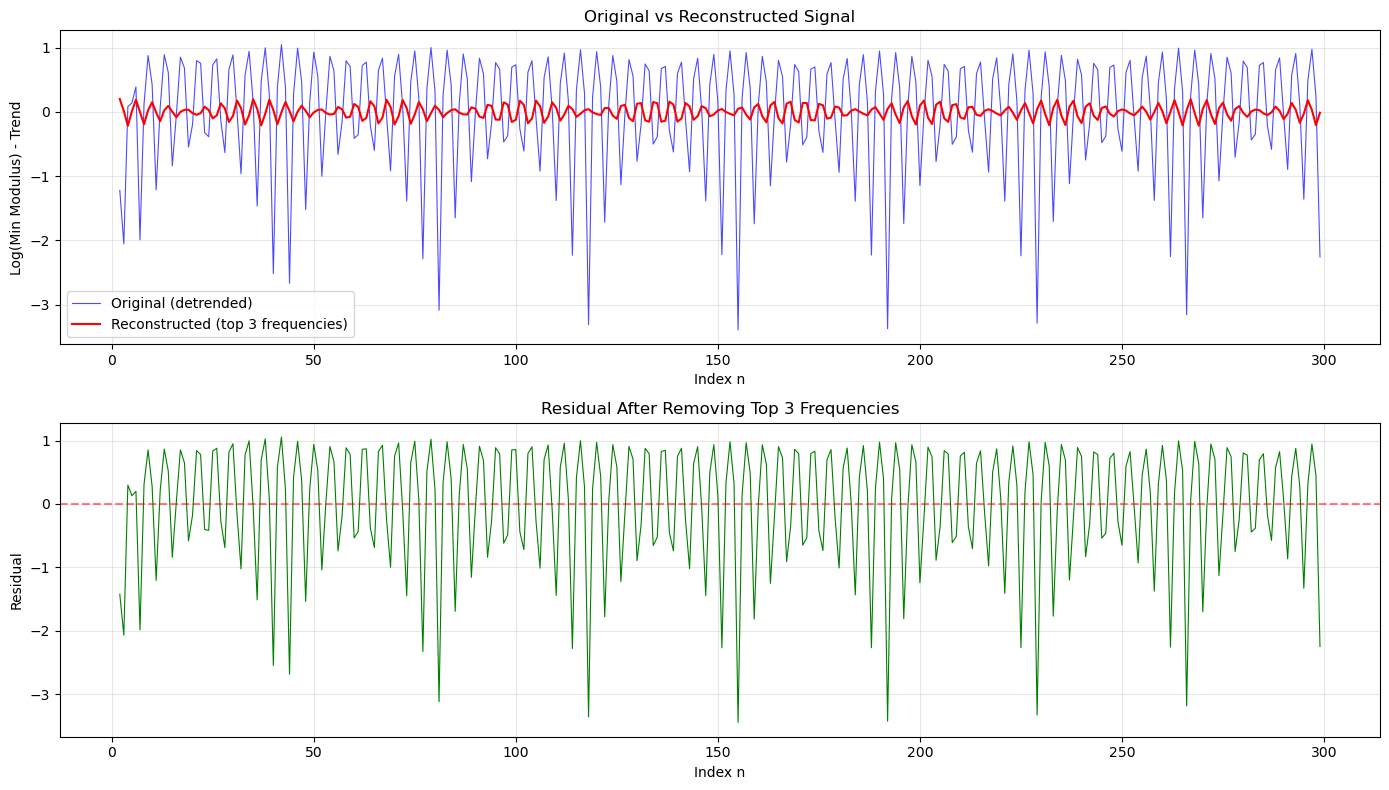


Analysis complete! Examine the plots and frequency table above.


In [5]:
import pickle
from sage.all import (QQ, sigma, nth_prime, matrix, flatten, polygen)
import pickle

Rc.<c> = RR[] # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< note
Rn.<n> = QQ[]
Rd.<d>=QQ[]
Rkk.<kk>=QQ[]

with open('/Users/barrybrent/data2/run9feb26no9.txt', 'rb') as rfile:
    c_polys = pickle.load(rfile)

    
mins_list=[]
for tupl in c_polys:
    n=tupl[0]
    print(n)
    poly=tupl[1]
    roots=poly.roots(ring=CC, multiplicities=False)
    aar = [r.abs() for r in roots]
    if aar!=[]:
        minn = min(aar)  
        mins_list.append((n,minn))
with open('/Users/barrybrent/data2/run10feb26no8.txt', 'wb') as wfile:
    pickle.dump(c_polys, wfile) # ouput snipped
p = list_plot(mins_list, plotjoined=True, axes_labels=['', ''])
print("MINIMUM MODULI")
p.show()

log_mins_list=[
    (pair[0],log(pair[1])) 
     for pair in mins_list]
p = list_plot(log_mins_list, plotjoined=True, axes_labels=['', ''])
print("LOG MINIMUM MODULI")
p.show()

# FOURIER ANALYSIS OF MINIMUM MODULI
# This cell performs spectral analysis on the minimum moduli sequence
# to detect periodicities, dominant frequencies, and oscillatory patterns

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# ==============================================================================
# 1. PREPARE THE DATA - Convert from SageMath to Python/NumPy types
# ==============================================================================

# Extract the data from mins_list and convert to Python floats
# This is crucial because SageMath uses its own numeric types
indices = np.array([float(pair[0]) for pair in mins_list], dtype=np.float64)
min_moduli = np.array([float(pair[1]) for pair in mins_list], dtype=np.float64)

# Also prepare the log-transformed data
log_min_moduli = np.log(min_moduli)

print(f"Data range: n = {int(indices[0])} to {int(indices[-1])}")
print(f"Number of data points: {len(indices)}")
print(f"Min modulus range: {min_moduli.min():.6f} to {min_moduli.max():.6f}")

# ==============================================================================
# 2. DETRENDING (Important for seeing oscillations)
# ==============================================================================

# For the log data, remove any polynomial trend to focus on oscillations
# We'll try both linear and quadratic detrending

# Linear detrend
log_detrended_linear = signal.detrend(log_min_moduli, type='linear')

# Polynomial detrend (degree 2)
poly_coeffs = np.polyfit(indices, log_min_moduli, deg=2)
poly_trend = np.polyval(poly_coeffs, indices)
log_detrended_poly = log_min_moduli - poly_trend

print(f"\nTrend removed. Detrended data std dev: {np.std(log_detrended_poly):.4f}")

# ==============================================================================
# 3. COMPUTE FOURIER TRANSFORM
# ==============================================================================

# Use FFT on the detrended log data
# The FFT reveals which "frequencies" (periodicities in n) are present

fft_result = np.fft.fft(log_detrended_poly)
fft_frequencies = np.fft.fftfreq(len(indices), d=1.0)  # d=1 means indices are spaced by 1

# Power spectrum (magnitude squared)
power_spectrum = np.abs(fft_result)**2

# Only keep positive frequencies (negative are redundant for real signals)
positive_freq_mask = fft_frequencies > 0
frequencies = fft_frequencies[positive_freq_mask]
power = power_spectrum[positive_freq_mask]

# Convert frequency to period: period = 1/frequency
# (period tells us "spikes repeat every X indices")
periods = 1.0 / frequencies

# ==============================================================================
# 4. IDENTIFY DOMINANT FREQUENCIES
# ==============================================================================

# Find the top 10 peaks in the power spectrum
peak_indices = signal.find_peaks(power, height=np.max(power)*0.1)[0]  # peaks at least 10% of max
peak_powers = power[peak_indices]
peak_periods = periods[peak_indices]

# Sort by power (strongest first)
sorted_indices = np.argsort(peak_powers)[::-1]
top_peaks = sorted_indices[:min(10, len(sorted_indices))]

print("\n" + "="*70)
print("TOP DOMINANT PERIODICITIES (in index n)")
print("="*70)
print(f"{'Rank':<6} {'Period':<12} {'Frequency':<12} {'Power':<15}")
print("-"*70)
for rank, idx in enumerate(top_peaks, 1):
    period = peak_periods[idx]
    freq = frequencies[peak_indices[idx]]
    pwr = peak_powers[idx]
    print(f"{rank:<6} {period:>10.2f}   {freq:>10.6f}   {pwr:>12.2e}")

# ==============================================================================
# 5. VISUALIZATIONS
# ==============================================================================

fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Plot 5.1: Original data (linear scale)
axes[0, 0].plot(indices, min_moduli, 'b-', linewidth=0.8)
axes[0, 0].set_xlabel('Index n')
axes[0, 0].set_ylabel('Minimum Modulus')
axes[0, 0].set_title('Original: Minimum Moduli')
axes[0, 0].grid(True, alpha=0.3)

# Plot 5.2: Log scale data
axes[0, 1].plot(indices, log_min_moduli, 'b-', linewidth=0.8)
axes[0, 1].set_xlabel('Index n')
axes[0, 1].set_ylabel('Log(Minimum Modulus)')
axes[0, 1].set_title('Log-transformed Minimum Moduli')
axes[0, 1].grid(True, alpha=0.3)

# Plot 5.3: Detrended data (shows oscillations more clearly)
axes[1, 0].plot(indices, log_detrended_poly, 'b-', linewidth=0.8)
axes[1, 0].set_xlabel('Index n')
axes[1, 0].set_ylabel('Log(Min Modulus) - Trend')
axes[1, 0].set_title('Detrended Log Data (Oscillations Emphasized)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Plot 5.4: Power Spectrum vs Frequency
axes[1, 1].semilogy(frequencies, power, 'b-', linewidth=0.8)
axes[1, 1].semilogy(frequencies[peak_indices[top_peaks]], 
                     peak_powers[top_peaks], 'ro', markersize=8, label='Dominant peaks')
axes[1, 1].set_xlabel('Frequency (cycles per index)')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('Power Spectrum vs Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, 0.5)  # Nyquist limit

# Plot 5.5: Power Spectrum vs Period (often more intuitive)
# Only plot periods up to half the data length (longer periods unreliable)
max_period = len(indices) / 2
period_mask = periods <= max_period
axes[2, 0].semilogy(periods[period_mask], power[period_mask], 'b-', linewidth=0.8)
# Mark dominant periods
for idx in top_peaks:
    if peak_periods[idx] <= max_period:
        axes[2, 0].semilogy(peak_periods[idx], peak_powers[idx], 'ro', markersize=8)
axes[2, 0].set_xlabel('Period (indices between repetitions)')
axes[2, 0].set_ylabel('Power')
axes[2, 0].set_title('Power Spectrum vs Period')
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].set_xlim(2, max_period)

# Plot 5.6: Spectrogram (time-frequency analysis using Short-Time Fourier Transform)
# This shows if periodicities change over the sequence
window_size = min(64, len(indices)//4)  # adaptive window size
f_spec, t_spec, Sxx = signal.spectrogram(log_detrended_poly, fs=1.0, 
                                          nperseg=window_size, 
                                          noverlap=window_size//2)
# Convert frequency axis to period for easier interpretation
period_spec = 1.0 / (f_spec + 1e-10)  # avoid division by zero
period_spec = period_spec[1:]  # remove DC component
Sxx = Sxx[1:, :]

# Plot with period on y-axis (inverted so small periods at bottom)
im = axes[2, 1].pcolormesh(indices[0] + t_spec, period_spec, 10*np.log10(Sxx + 1e-10),
                           shading='gouraud', cmap='viridis')
axes[2, 1].set_xlabel('Index n')
axes[2, 1].set_ylabel('Period')
axes[2, 1].set_title('Spectrogram: How Periodicities Change with n')
axes[2, 1].set_ylim(2, min(100, max_period))
axes[2, 1].invert_yaxis()  # small periods at bottom
plt.colorbar(im, ax=axes[2, 1], label='Power (dB)')

plt.tight_layout()
plt.show()

# ==============================================================================
# 6. FILTERED SIGNAL (reconstruct using only dominant frequencies)
# ==============================================================================

# Reconstruct signal using only the top 3 dominant frequencies
# This shows what the "pure" oscillatory pattern looks like

print("\n" + "="*70)
print("SIGNAL RECONSTRUCTION")
print("="*70)

reconstructed = np.zeros_like(log_detrended_poly)
for rank, idx in enumerate(top_peaks[:3], 1):  # Use top 3 frequencies
    freq = frequencies[peak_indices[idx]]
    period = peak_periods[idx]
    # Get amplitude and phase from FFT
    amp = np.abs(fft_result[peak_indices[idx]]) / len(indices)
    phase = np.angle(fft_result[peak_indices[idx]])
    # Reconstruct this component
    component = amp * np.cos(2 * np.pi * freq * indices + phase)
    reconstructed += component
    print(f"Component {rank}: Period = {period:.2f}, Amplitude = {amp:.4f}")

# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(indices, log_detrended_poly, 'b-', linewidth=0.8, alpha=0.7, label='Original (detrended)')
axes[0].plot(indices, reconstructed, 'r-', linewidth=1.5, label='Reconstructed (top 3 frequencies)')
axes[0].set_xlabel('Index n')
axes[0].set_ylabel('Log(Min Modulus) - Trend')
axes[0].set_title('Original vs Reconstructed Signal')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual (what's left after removing dominant frequencies)
residual = log_detrended_poly - reconstructed
axes[1].plot(indices, residual, 'g-', linewidth=0.8)
axes[1].set_xlabel('Index n')
axes[1].set_ylabel('Residual')
axes[1].set_title('Residual After Removing Top 3 Frequencies')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Analysis complete! Examine the plots and frequency table above.")
print("="*70)